# **TriviaQA and Longformer**

This notebook will apply visualization techniques to a Question Answering System that uses as a base the Longformer model from the huggingface library. For starters we will use the TriviaQA dataset that has already been prepared by huggingface to be used with its longformer model.

The visualizations include:

- **The snippet of text from where the answer was obtained.**
- **A heatmap of the text attentions**: (using jiesutd's TAHV implementation) Highlight attention score on input text. This gives insight into what parts of the input text the model is focusing on and obtaining its information from, which parts are being ignored and which are of major importance. (This should significantly increase the interpretability of the models predictions).

- **The top x predictions**: For the cases where more than one prediction was found. For each prediction showcase the score and attention scores.

- **Heatmap (pandas) of weights by layer**: More difficult to interpret but still useful in some cases.

- **Data visualization**: Having an insight of the data used is crucial.


## **Setup**:

Install transformers library and relevant github repositories:

In [1]:
!pip install transformers
!git clone https://github.com/jiesutd/Text-Attention-Heatmap-Visualization

Cloning into 'Text-Attention-Heatmap-Visualization'...


Download the pretrained longformer tokenizer and model (For now we are using the LongformerForQuestionAnswering model trained on triviaqa without further transfer learning)

In [ ]:
from transformers import LongformerTokenizer, LongformerForQuestionAnswering
import torch

tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-large-4096-finetuned-triviaqa")
model = LongformerForQuestionAnswering.from_pretrained("allenai/longformer-large-4096-finetuned-triviaqa")

## **Demo:**

Choose an input text (for the example below we picked a random extract from Wikipedia and set it as our QA 'context'). Once you have a text, think of a question related to it. (You can also pick a non-related question. In which case there will be no answer)

In [3]:
### Random text extracted from Wikipedia article found at: https://en.wikipedia.org/wiki/Cleopatra

text = f"Cleopatra VII Philopator (Koinē Greek: Κλεοπάτρα Φιλοπάτωρ;[5] 69 – 10 or 12 August 30 BC)[note 2] was the last\
         active ruler of the Ptolemaic Kingdom of Egypt.[note 5] As a member of the Ptolemaic dynasty, she was a descendant \
         of its founder Ptolemy I Soter, a Macedonian Greek general and companion of Alexander the Great.[note 6] After the \
         death of Cleopatra, Egypt became a province of the Roman Empire, marking the end of the second to last Hellenistic \
         state and the age that had lasted since the reign of Alexander (336–323 BC).[note 7] Her native language was Koine \
         Greek, and she was the only Ptolemaic ruler to learn the Egyptian language.[note 8] In 58 BC, Cleopatra presumably \
         accompanied her father, Ptolemy XII Auletes, during his exile to Rome after a revolt in Egypt (a Roman client state) \
         allowing his daughter Berenice IV to claim the throne. Berenice was killed in 55 BC when Ptolemy returned to Egypt \
         with Roman military assistance. When he died in 51 BC, the joint reign of Cleopatra and her brother Ptolemy XIII began, \
         but a falling-out between them led to open civil war. After losing the 48 BC Battle of Pharsalus in Greece against his \
         rival Julius Caesar (a Roman dictator and consul) in Caesars Civil War, the Roman statesman Pompey fled to Egypt. Pompey \
         had been a political ally of Ptolemy XII, but Ptolemy XIII, at the urging of his court eunuchs, had Pompey ambushed and \
         killed before Caesar arrived and occupied Alexandria. Caesar then attempted to reconcile the rival Ptolemaic siblings, \
         but Ptolemys chief adviser Potheinos viewed Caesars terms as favoring Cleopatra, so his forces besieged her and Caesar \
         at the palace. Shortly after the siege was lifted by reinforcements, Ptolemy XIII died in the 47 BC Battle of the Nile; \
         Cleopatra's half-sister Arsinoe IV was eventually exiled to Ephesus for her role in carrying out the siege. Caesar \
         declared Cleopatra and her brother Ptolemy XIV joint rulers, but maintained a private affair with Cleopatra that produced \
         a son, Caesarion. Cleopatra traveled to Rome as a client queen in 46 and 44 BC, where she stayed at Caesar's villa. After \
         the assassinations of Caesar and (on her orders) Ptolemy XIV in 44 BC, she named Caesarion co-ruler. In the Liberators civil \
         war of 43–42 BC, Cleopatra sided with the Roman Second Triumvirate formed by Caesar's grandnephew and heir Octavian, Mark \
         Antony, and Marcus Aemilius Lepidus. After their meeting at Tarsos in 41 BC, the queen had an affair with Antony. He \
         carried out the execution of Arsinoe at her request, and became increasingly reliant on Cleopatra for both funding and \
         military aid during his invasions of the Parthian Empire and the Kingdom of Armenia. The Donations of Alexandria declared \
         their children Alexander Helios, Cleopatra Selene II, and Ptolemy Philadelphus rulers over various erstwhile territories \
         under Antonys triumviral authority. This event, their marriage, and Antonys divorce of Octavians sister Octavia Minor led \
         to the Final War of the Roman Republic. Octavian engaged in a war of propaganda, forced Antonys allies in the Roman Senate \
         to flee Rome in 32 BC, and declared war on Cleopatra. After defeating Antony and Cleopatra's naval fleet at the 31 BC Battle \
         of Actium, Octavian's forces invaded Egypt in 30 BC and defeated Antony, leading to Antony's suicide. When Cleopatra learned \
         that Octavian planned to bring her to his Roman triumphal procession, she killed herself by poisoning, contrary to the \
         popular belief that she was bitten by an asp. Cleopatras legacy survives in ancient and modern works of art. Roman \
         historiography and Latin poetry produced a generally critical view of the queen that pervaded later Medieval and \
         Renaissance literature. In the visual arts, her ancient depictions include Roman busts, paintings, and sculptures, cameo \
         carvings and glass, Ptolemaic and Roman coinage, and reliefs. In Renaissance and Baroque art, she was the subject of many \
         works including operas, paintings, poetry, sculptures, and theatrical dramas. She has become a pop culture icon of Egyptomania \
         since the Victorian era, and in modern times, Cleopatra has appeared in the applied and fine arts, burlesque satire, Hollywood \
         films, and brand images for commercial products."

### Now pick any question:

question = f"What was Cleopatra's half-sister called?"

The inputs are encoded before being run through the model. Then the outputs are converted form 'start-' and 'end-tokens' to the span of 'answer-tokens'. which is then decoded by the longformer tokenizer:

In [4]:
## Model being used is: LongformerForQuestionAnswering.from_pretrained("allenai/longformer-large-4096-finetuned-triviaqa")

encoding = tokenizer(question, text, return_tensors="pt")
input_ids = encoding["input_ids"]
attention_mask = encoding["attention_mask"]
outputs = model(input_ids, attention_mask=attention_mask)
start_logits = outputs.start_logits
end_logits = outputs.end_logits
all_tokens = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())
answer_tokens = all_tokens[torch.argmax(start_logits) :torch.argmax(end_logits)+1]
answer = tokenizer.decode(tokenizer.convert_tokens_to_ids(answer_tokens))

/usr/local/lib/python3.6/dist-packages/transformers/models/longformer/modeling_longformer.py:397: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  sep_token_indices = (input_ids == sep_token_id).nonzero()


In [5]:
answer

' Arsinoe'

In [6]:
# So far no attentions can be obtained from the model since it is pretrained. Later on I will use transfer learning and obtain
# local, global and self attentions.

#attentions = outputs.attentions
#global_attentions = outputs.global_attentions
#print(outputs)

## **Visualizing Attention**

The first thing we do to interpret the prediction is to use the text-attention heatmap visualization tool presented by jiesutd in https://github.com/jiesutd/Text-Attention-Heatmap-Visualization.

(For now we do not have attentions so we will create a random attention vector.)

In [7]:
%cd Text-Attention-Heatmap-Visualization/
from text_attention import generate
import random

words = text.split()
word_num = len(words)
attention = [(x+1.)/word_num*100 for x in range(word_num)]    #Temporary random attentions
random.seed(42)
random.shuffle(attention)
color = 'blue'  #'red'
generate(words, attention, "sample.tex", color)
%cd ..

/content/Text-Attention-Heatmap-Visualization


**TODO:** use pdflatex and pdf2image to transform the heatmap to a png that can be displayed as done in this cell. (Automatize the process)

/content


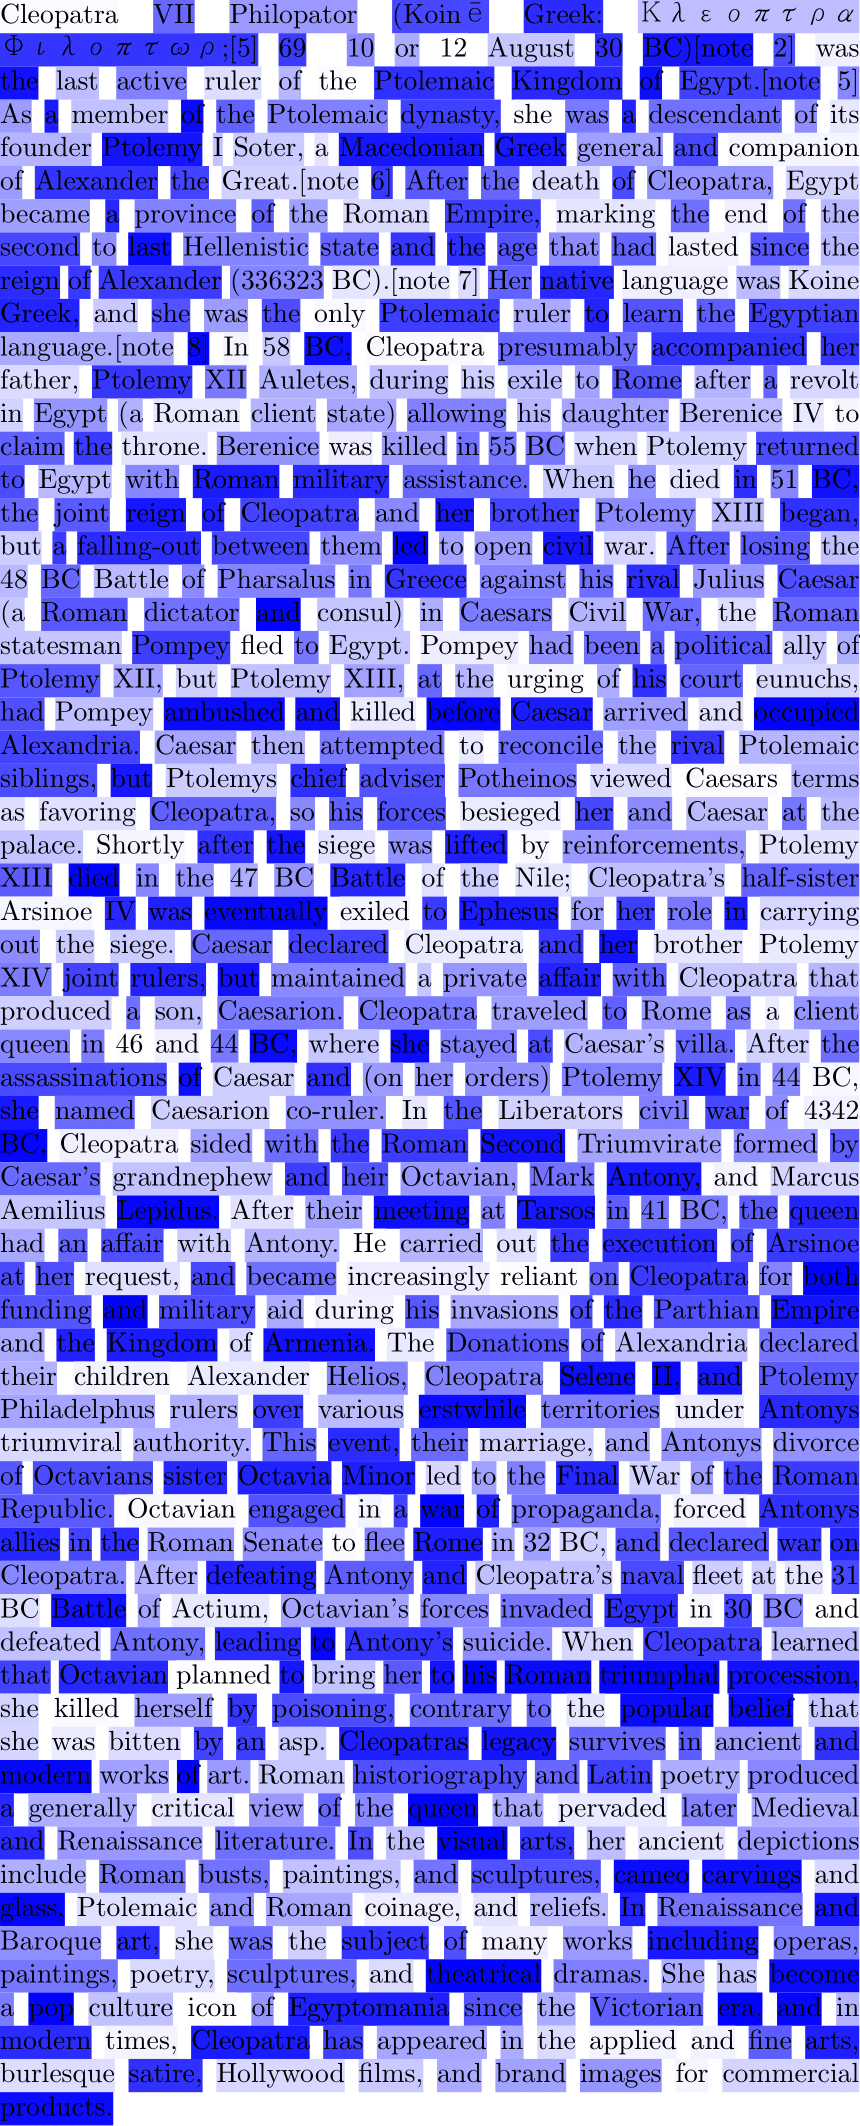

In [10]:
from IPython.display import Image
Image(filename='sample_tex.png')